# Statistical analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. Then the set of differentially expressed genes (DEGs) obtained from this analysis are used to perform gene set enrichment analysis (GSEA) to identify pathways enriched in these set of DEGs.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# User selected experiment id
project_id = "SRP000762"

In [4]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs=25

In [5]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    "SRP000762_groups.tsv")

## Install R libraries

In [6]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')
#BiocManager::install('clusterProfiler')
#BiocManager::install("org.Hs.eg.db")

NULL


## Differential expression analysis

In [7]:
%%R
library('limma')

**Get differentially expressed genes from template experiment**

In [8]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../functions/DE_analysis.R')

get_DE_stats(metadata_file,
             project_id, 
             template_data_file,
             "template",
             local_dir,
             "real")

[1] 60


**Get differentially expressed genes from each simulated experiment**

In [9]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
  simulated_data_file <- paste(local_dir, "pseudo_experiment/selected_simulated_data_", project_id, "_", i, ".txt", sep="")
  cat(paste("running file: ", simulated_data_file, "...\n", sep=""))
  
  run_output <- get_DE_stats(metadata_file,
                             project_id, 
                             simulated_data_file,
                             "simulated",
                             local_dir,
                             i)
  
  num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
}
median(num_sign_DEGs_simulated)

running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_0.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_1.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_2.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_3.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_4.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_5.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_6.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/pseudo_experiment/selected_simulated_data_SRP000762_7.txt...
running file: /home/alexandra/Documents/

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


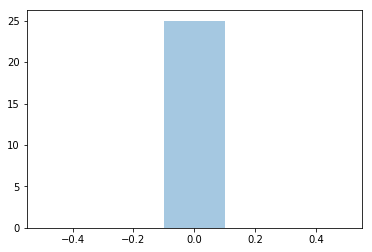

In [10]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Observation:** All simulated experiments found 0 DEGs using adjusted p-value cutoff of <5%

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Reddy et. al. publication](https://www.ncbi.nlm.nih.gov//pubmed/19801529), which found:
* 234 genes with a significant (FDR < 5%) change in expression in response to DEX treatment. 
* After removing pseudogenes (listed in Supplemental Table S3), 209 differentially expressed genes remained 
* Of the DEX-responsive genes, more showed increases in transcript levels 123 (59%) than showed decreases 86 (41%), and the up-regulation was slightly but significantly stronger than the down-regulation

By comparison:
* Our study found 60 DEGs instead of 234. 
* Spot checking the genes identified with their list of DEX-responsive genes (Supplementary Dataset 2), we found the same genes and FC direction was consistent though magnitudes of theirs was lower compared to ours. 

In [11]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [12]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[template_DE_stats['adj.P.Val']<0.05]
print(template_DEGs.shape)
template_DEGs.head()

(60, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000067082.14,19.385246,18.673139,14.055682,2.342010e-12,1.359233e-07,9.739709
ENSG00000177606.6,-8.236487,9.185753,-13.126898,8.859555e-12,2.570910e-07,9.292456
ENSG00000114315.3,-6.285228,6.042663,-12.840532,1.355507e-11,2.622318e-07,9.141666
ENSG00000185950.8,8.790781,17.705828,12.594113,1.966140e-11,2.852721e-07,9.006626
ENSG00000095752.6,-7.505790,7.299177,-12.204218,3.582671e-11,4.158550e-07,8.782431


In [13]:
#%%R
#library(EnhancedVolcano)

In [14]:
#%%R -i project_id -i template_DE_stats_file -i local_dir

#source('../functions/DE_analysis.R')

#create_volcano(template_DE_stats_file,
#               project_id,
#               "adj.P.Val",
#               local_dir)

## Gene set enrichment analysis

**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

**Note:** Since there were 0 differentially expressed genes using simulated experiments, we used gene set enrichement analysis instead of over-representation analysis to get ranking of genes

In [15]:
%%R
library(clusterProfiler)
library(org.Hs.eg.db)
library(DOSE)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/py

**Get pathway enrichment for template experiment**

In [16]:
%%R -i template_DE_stats_file  -o enriched_pathways

source('../functions/GSEA_analysis.R')

enriched_pathways <- find_enriched_pathways(template_DE_stats_file)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [17]:
print(enriched_pathways.shape)
enriched_pathways.head()

(1028, 12)


,ONTOLOGY,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
0,MF,GO:0000049,tRNA binding,60,0.525192,1.546860,0.000999,0.013768,0.011039,17488,"tags=52%, list=30%, signal=36%",ENSG00000124571/ENSG00000129480/ENSG0000007250...
1,BP,GO:0000070,mitotic sister chromatid segregation,152,0.515293,1.604110,0.000999,0.013768,0.011039,16866,"tags=52%, list=29%, signal=37%",ENSG00000154473/ENSG00000121152/ENSG0000016784...
2,BP,GO:0000075,cell cycle checkpoint,215,0.486637,1.537440,0.000999,0.013768,0.011039,16017,"tags=47%, list=28%, signal=34%",ENSG00000182973/ENSG00000154473/ENSG0000016841...
3,BP,GO:0000077,DNA damage checkpoint,144,0.487972,1.516464,0.000999,0.013768,0.011039,17564,"tags=49%, list=30%, signal=34%",ENSG00000182973/ENSG00000168411/ENSG0000013984...
4,BP,GO:0000082,G1/S transition of mitotic cell cycle,267,0.439629,1.399748,0.000999,0.013768,0.011039,14089,"tags=37%, list=24%, signal=28%",ENSG00000198987/ENSG00000199157/ENSG0000020759...


**Get pathway enrichment for simulated experiments**

In [18]:
%%R -i project_id -i local_dir -i num_runs 

source('../functions/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    cat(paste("running file: ", simulated_DE_stats_file, "...\n", sep=""))
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file)
    
    out_file = paste(local_dir, "GSEA_stats/GSEA_simulated_data_", project_id,"_", i, ".txt", sep="")
    write.table(enriched_pathways, file = out_file, row.names = T, sep = "\t", quote = F)
    }

running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_0.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_1.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_2.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_3.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_4.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_5.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_6.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_7.txt...
running file: /home/alexandra/Documents/Data/Rank_pathways/DE_stats/DE_stats_simulated_data_SRP000762_8.txt...
r

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: no term enriched under specific pvalueCutoff...

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in str_count(res$core_enrichment, "/") + 1 : 
  non-numeric argument to binary operator

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: There were 50 or more warnings (use warnings() to see the first 50)
  warnings.warn(x, RRuntimeWarning)


## Statistics

**Template experiment**

In [19]:
col_to_rank = 'enrichmentScore'

In [20]:
# zip GO ID and description to get unique key
enriched_pathways["ID_description"] = enriched_pathways["ID"] +"-"+enriched_pathways["Description"]

In [21]:
# Get ranks of template experiment
# Rank pathways by highest enrichment score
enriched_pathways['ranking'] = enriched_pathways[col_to_rank].rank(ascending = 0) 
enriched_pathways = enriched_pathways.sort_values(by=col_to_rank, ascending=False)
enriched_pathways

,ONTOLOGY,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ID_description,ranking
637,MF,GO:0017166,vinculin binding,11,0.764407,1.851843,0.001083,0.014215,0.011397,8431,"tags=64%, list=15%, signal=54%",ENSG00000137076/ENSG00000173402/ENSG0000008915...,GO:0017166-vinculin binding,1.0
638,CC,GO:0019774,"proteasome core complex, beta-subunit complex",11,0.756475,1.832628,0.001083,0.014215,0.011397,10764,"tags=73%, list=19%, signal=59%",ENSG00000126067/ENSG00000159377/ENSG0000024006...,"GO:0019774-proteasome core complex, beta-subun...",2.0
592,CC,GO:0000314,organellar small ribosomal subunit,28,0.744290,2.067121,0.001003,0.013768,0.011039,12851,"tags=75%, list=22%, signal=58%",ENSG00000135972/ENSG00000132676/ENSG0000006258...,GO:0000314-organellar small ribosomal subunit,3.5
594,CC,GO:0005763,mitochondrial small ribosomal subunit,28,0.744290,2.067121,0.001003,0.013768,0.011039,12851,"tags=75%, list=22%, signal=58%",ENSG00000135972/ENSG00000132676/ENSG0000006258...,GO:0005763-mitochondrial small ribosomal subunit,3.5
639,CC,GO:0000805,X chromosome,10,0.741553,1.759370,0.001100,0.014389,0.011537,10394,"tags=60%, list=18%, signal=49%",ENSG00000121931/ENSG00000132475/ENSG0000012337...,GO:0000805-X chromosome,5.0
608,CC,GO:0016282,eukaryotic 43S preinitiation complex,17,0.723414,1.900784,0.001017,0.013768,0.011039,14095,"tags=88%, list=24%, signal=67%",ENSG00000184110/ENSG00000100353/ENSG0000020560...,GO:0016282-eukaryotic 43S preinitiation complex,6.0
861,BP,GO:1903441,protein localization to ciliary membrane,11,0.721912,1.748895,0.003250,0.031613,0.025346,11903,"tags=73%, list=21%, signal=58%",ENSG00000203965/ENSG00000157796/ENSG0000021441...,GO:1903441-protein localization to ciliary mem...,7.0
615,BP,GO:0001732,formation of cytoplasmic translation initiatio...,16,0.720854,1.866702,0.001029,0.013768,0.011039,14095,"tags=88%, list=24%, signal=66%",ENSG00000184110/ENSG00000100353/ENSG0000020560...,GO:0001732-formation of cytoplasmic translatio...,8.0
640,BP,GO:2000628,regulation of miRNA metabolic process,10,0.719859,1.707898,0.001100,0.014389,0.011537,12225,"tags=50%, list=21%, signal=39%",ENSG00000135870/ENSG00000164329/ENSG0000008824...,GO:2000628-regulation of miRNA metabolic process,9.0
635,BP,GO:0008298,intracellular mRNA localization,13,0.718866,1.798306,0.001052,0.013840,0.011096,13021,"tags=54%, list=22%, signal=42%",ENSG00000108349/ENSG00000130713/ENSG0000017182...,GO:0008298-intracellular mRNA localization,10.0


In [22]:
# Make dictionary {GO ID-description:rank}
template_rank_dict = dict(zip(enriched_pathways["ID_description"], 
                              enriched_pathways["ranking"]
                             ))
template_rank_dict

{'GO:0017166-vinculin binding': 1.0,
 'GO:0019774-proteasome core complex, beta-subunit complex': 2.0,
 'GO:0000314-organellar small ribosomal subunit': 3.5,
 'GO:0005763-mitochondrial small ribosomal subunit': 3.5,
 'GO:0000805-X chromosome': 5.0,
 'GO:0016282-eukaryotic 43S preinitiation complex': 6.0,
 'GO:1903441-protein localization to ciliary membrane': 7.0,
 'GO:0001732-formation of cytoplasmic translation initiation complex': 8.0,
 'GO:2000628-regulation of miRNA metabolic process': 9.0,
 'GO:0008298-intracellular mRNA localization': 10.0,
 'GO:0002566-somatic diversification of immune receptors via somatic mutation': 11.0,
 'GO:0005852-eukaryotic translation initiation factor 3 complex': 12.0,
 'GO:0016446-somatic hypermutation of immunoglobulin genes': 13.0,
 'GO:0030952-establishment or maintenance of cytoskeleton polarity': 14.0,
 'GO:0030621-U4 snRNA binding': 15.0,
 'GO:0002178-palmitoyltransferase complex': 16.0,
 'GO:0016251-RNA polymerase II general transcription initi

**Check**

Again, we want to compare our ranked pathways found against what was reported in the original publication.

*The DEX-responsive genes that we identified are primarily implicated in two broad classes: stress response and development (Table 1; Reimand et al. 2007). Comparison to Gene Ontology (GO) categories (Ashburner et al. 2000) revealed that the identified genes are involved in stress response (P = 6 × 10−11), organ development (P = 5 × 10−15), cell differentiation (P = 1 × 10−11), hormone secretion (P = 4 × 10−7), and apoptosis (P = 5 × 10−12).*

We found pathways that are consistent with what publication found: pathways related to anatomical structure (i.e. vinculin, ) and cell differentiation (i.e. centromeric sister chromatid cohesion), hormone secretion (i.e. somatic hypermutation of immunoglobulin genes)

**Simulated experiments**

In [23]:
def FullMergeDict(D1, D2):
    for key, value in D1.items():
        if key in D2:
            if type(value) is dict:
                FullMergeDict(D1[key], D2[key])
            else:
                if type(value) in (int, float, str):
                    D1[key] = [value]
                if type(D2[key]) is list:
                    D1[key].extend(D2[key])
                else:
                    D1[key].append(D2[key])
    for key, value in D2.items():
        if key not in D1:
            D1[key] = value
    return(D1)

In [24]:
# Get distribution of ranks for simulated experiments
for i in range(num_runs):
    simulated_GSEA_file = os.path.join(
        local_dir, 
        "GSEA_stats",
        "GSEA_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_enriched_pathways = pd.read_csv(
        simulated_GSEA_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # zip GO ID and description to get unique key
    simulated_enriched_pathways["ID_description"] = simulated_enriched_pathways["ID"]+"-"+simulated_enriched_pathways["Description"]
    
    # Get ranks of simulated experiment
    simulated_enriched_pathways['ranking'] = simulated_enriched_pathways[col_to_rank].rank(ascending = 0) 
    simulated_enriched_pathways = simulated_enriched_pathways.sort_values(by=col_to_rank, ascending=False)
    
    if i == 0:
        # Initiate dictionary {GO ID-description:rank}
        simulated_rank_dict = dict(zip(simulated_enriched_pathways["ID_description"], 
                                      simulated_enriched_pathways["ranking"]
                                     ))
    else:
        tmp_simulated_rank_dict = dict(zip(simulated_enriched_pathways["ID_description"], 
                                      simulated_enriched_pathways["ranking"]
                                     ))
        
        simulated_rank_dict = FullMergeDict(simulated_rank_dict, tmp_simulated_rank_dict)

In [25]:
simulated_rank_dict

{'GO:0000353-formation of quadruple SL/U4/U5/U6 snRNP': [2.0,
  3.0,
  4.0,
  5.0,
  3.0,
  54.0,
  4.0,
  12.0,
  29.0,
  6.0,
  2.0,
  41.0,
  3.0,
  3.0,
  2.0,
  25.0,
  52.0,
  11.0,
  16.0],
 'GO:0045291-mRNA trans splicing, SL addition': [2.0,
  3.0,
  4.0,
  5.0,
  3.0,
  54.0,
  4.0,
  12.0,
  29.0,
  6.0,
  2.0,
  41.0,
  3.0,
  3.0,
  2.0,
  25.0,
  52.0,
  11.0,
  16.0],
 'GO:0000365-mRNA trans splicing, via spliceosome': [2.0,
  3.0,
  4.0,
  5.0,
  3.0,
  54.0,
  4.0,
  12.0,
  29.0,
  6.0,
  2.0,
  41.0,
  3.0,
  3.0,
  2.0,
  25.0,
  52.0,
  11.0,
  16.0],
 'GO:1904851-positive regulation of establishment of protein localization to telomere': [5.0,
  2.0,
  17.0,
  9.0,
  2.0],
 'GO:1903405-protein localization to nuclear body': [5.0, 2.0, 17.0, 9.0, 2.0],
 'GO:1904867-protein localization to Cajal body': [5.0, 2.0, 17.0, 9.0, 2.0],
 'GO:0050786-RAGE receptor binding': [7.0, 16.0, 34.0, 12.0, 29.0, 22.0],
 'GO:1905651-regulation of artery morphogenesis': [8.0,
  27.0,
 

## Manually examine enriched pathways
Examine the enriched pathways identified from template experiment -- How are these enriched pathways ranked in the simulated experiments?

Recall that there were 25 simulated experiments

In [26]:
# Compare template rank vs median simulated rank 
# Print those pathways where template rank < simulated rank (template is higher ranked than simulated)
# Some of these are pathways that are potentially template-specific

for key, val in template_rank_dict.items():
    if key in simulated_rank_dict.keys():
        diff_rank = val - np.median(simulated_rank_dict[key])
        if diff_rank < 10:
            print(key)
            print("Template rank: ", val)
            print("Median simulated rank: ", np.median(simulated_rank_dict[key]))

GO:0019774-proteasome core complex, beta-subunit complex
Template rank:  2.0
Median simulated rank:  1.0
GO:0000314-organellar small ribosomal subunit
Template rank:  3.5
Median simulated rank:  238.5
GO:0005763-mitochondrial small ribosomal subunit
Template rank:  3.5
Median simulated rank:  238.5
GO:2000628-regulation of miRNA metabolic process
Template rank:  9.0
Median simulated rank:  17.0
GO:0002566-somatic diversification of immune receptors via somatic mutation
Template rank:  11.0
Median simulated rank:  57.0
GO:0016446-somatic hypermutation of immunoglobulin genes
Template rank:  13.0
Median simulated rank:  69.0
GO:0030952-establishment or maintenance of cytoskeleton polarity
Template rank:  14.0
Median simulated rank:  20.5
GO:0030621-U4 snRNA binding
Template rank:  15.0
Median simulated rank:  35.0
GO:0072321-chaperone-mediated protein transport
Template rank:  20.0
Median simulated rank:  57.0
GO:0030950-establishment or maintenance of actin cytoskeleton polarity
Templat

GO:0000794-condensed nuclear chromosome
Template rank:  742.0
Median simulated rank:  956.0
GO:0005924-cell-substrate adherens junction
Template rank:  743.0
Median simulated rank:  751.0
GO:0043161-proteasome-mediated ubiquitin-dependent protein catabolic process
Template rank:  744.0
Median simulated rank:  1392.0
GO:0030117-membrane coat
Template rank:  745.5
Median simulated rank:  1881.5
GO:0048475-coated membrane
Template rank:  745.5
Median simulated rank:  1881.5
GO:0009145-purine nucleoside triphosphate biosynthetic process
Template rank:  747.0
Median simulated rank:  1192.0
GO:0000932-P-body
Template rank:  748.0
Median simulated rank:  861.0
GO:0006900-vesicle budding from membrane
Template rank:  750.0
Median simulated rank:  916.0
GO:0001650-fibrillar center
Template rank:  751.0
Median simulated rank:  1557.0
GO:0044389-ubiquitin-like protein ligase binding
Template rank:  753.0
Median simulated rank:  962.0
GO:1902806-regulation of cell cycle G1/S phase transition
Templ

In [27]:
# Compare template rank vs median simulated rank 
# Print those pathways that ranked high in template experiment AND have similar ranks in simulated experiment
for key, val in template_rank_dict.items():
    if key in simulated_rank_dict.keys():
        diff_rank = val - np.median(simulated_rank_dict[key])
        if (val < 50) and (abs(diff_rank) < 10):
            print(key)
            print("Template rank: ", val)
            print("Median simulated rank: ", np.median(simulated_rank_dict[key]))

GO:0019774-proteasome core complex, beta-subunit complex
Template rank:  2.0
Median simulated rank:  1.0
GO:2000628-regulation of miRNA metabolic process
Template rank:  9.0
Median simulated rank:  17.0
GO:0030952-establishment or maintenance of cytoskeleton polarity
Template rank:  14.0
Median simulated rank:  20.5
GO:0090151-establishment of protein localization to mitochondrial membrane
Template rank:  32.0
Median simulated rank:  33.0
GO:0051095-regulation of helicase activity
Template rank:  33.0
Median simulated rank:  35.0
GO:0000940-condensed chromosome outer kinetochore
Template rank:  42.0
Median simulated rank:  51.0


There are a few immune pathways that are template-enriched but there are others that look to be involved in cellular maintenancem, which I wouldn't expect to be specific to these experiment.

For GSEA I am currently using the p-values from the DE analysis to rank genes, should I try using avg gene expression instead..? Maybe p-values don't cluster genes as much..?

Note: this notebook takes ~1hr to run

**Check:**
* Are there template-specific pathways (i.e. pathways specific to Dexamethasone treatment) that we can use as a positive?
* Are there agnostic pathways that we can use as a negative control?